# Causal Curiosity RL 

In [1]:
%matplotlib inline

In [2]:
pip install gymnasium


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



#1 Solving Blackjack with Q-Learning


## Imports and Environment Setup




In [3]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




## Building an agent

Let’s build a ``Q-learning agent`` to solve *Blackjack-v1*! We’ll need
some functions for picking an action and updating the agents action
values. To ensure that the agents explores the environment, one possible
solution is the ``epsilon-greedy`` strategy, where we pick a random
action with the percentage ``epsilon`` and the greedy action (currently
valued as the best) ``1 - epsilon``.




In [4]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [5]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [6]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

In [7]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:10<00:00, 9980.18it/s]


## Visualizing the training




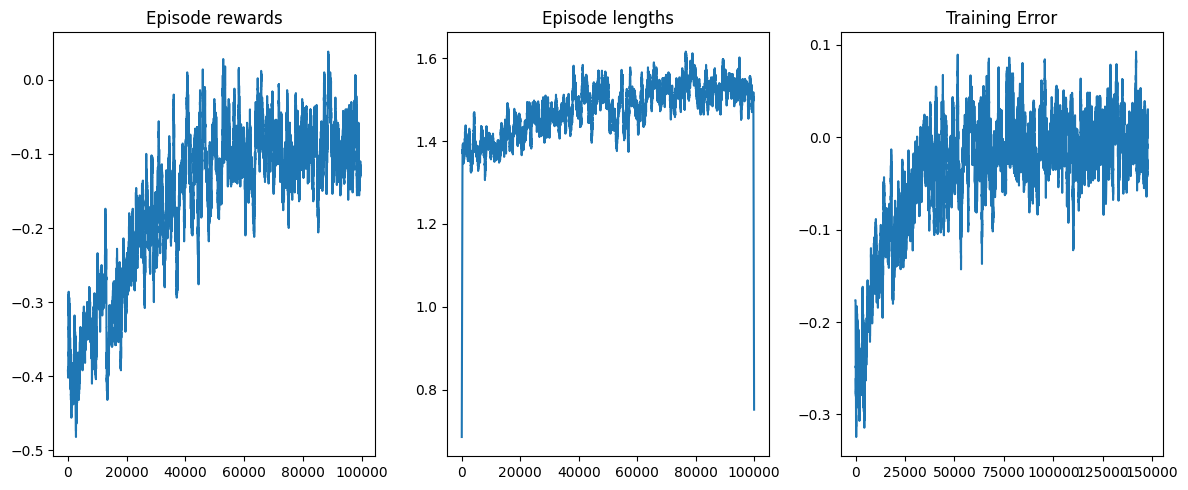

In [8]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

<img src="file://_static/img/tutorials/blackjack_training_plots.png">




## Visualising the policy



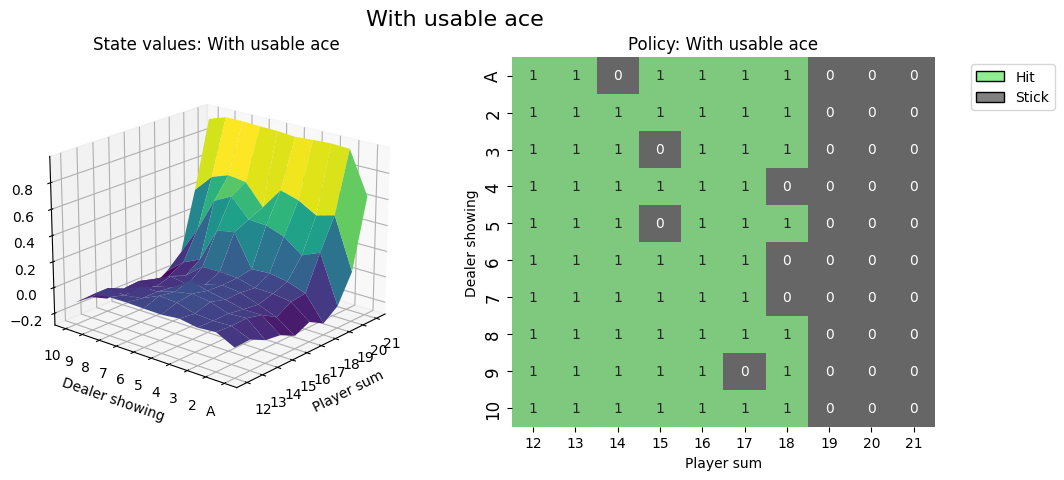

In [9]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




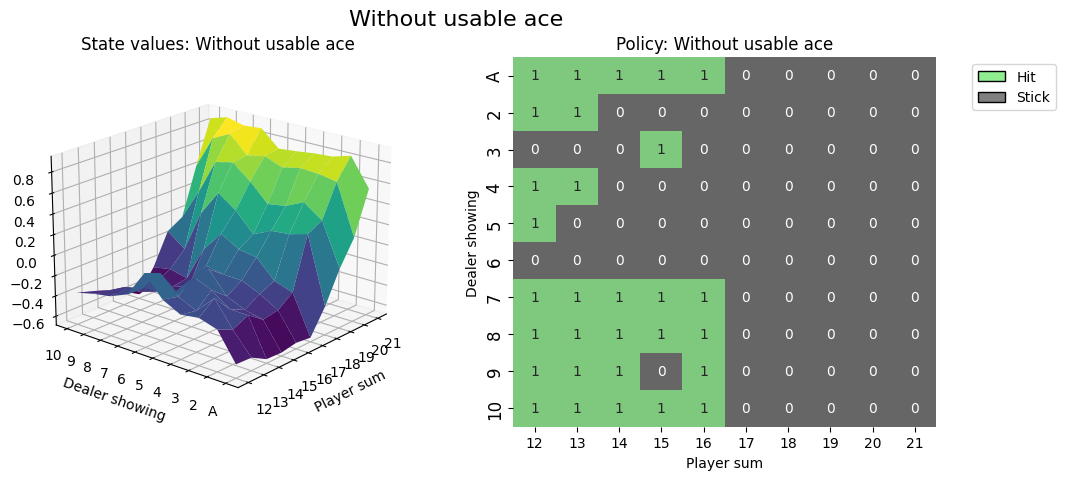

In [10]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

<img src="file://_static/img/tutorials/blackjack_without_usable_ace.png">

It's good practice to call env.close() at the end of your script,
so that any used resources by the environment will be closed.




## Causal Curiosity Agent



In [11]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.graph import SHD

def shd_cl_metric(new_graph, graph):

    if len(self.history) < 5:
        return 0
    else:
        metric = SHD.SHD(new_graph, graph)
        
        return metric.get_shd()

def pc_algo(history):

    
    #print('pc hsitory', history)
    array_data = history #dicts_to_numpy_array(history)

    
    cg = pc(array_data, alpha=0.2, verbose=False, show_progress=False)#, alpha=0.05, indep_test="chisq")
    

    return cg.G

class CausalBlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
        beta: float = 0.2,
        beta_discount: float = 0.1
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.d_values = np.zeros(env.action_space.n)


        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.beta = beta
        self.beta_discount = beta_discount

        self.training_error = []

        self.history = []

        self.causal_model = None

    def shd_cl_metric(self, new_graph, graph):
        metric = SHD.SHD(new_graph, graph)
        return metric.get_shd()

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return int(np.argmax(self.d_values)) 

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        reward_int = 0
        self.history.append(next_obs)
        
        if len(self.history) > 5 and (len(self.history) % 10 == 0):
            new_causal_model = self.compute_causal_model()
            if self.causal_model == None:
                self.causal_model = new_causal_model
            else:
                reward_int = self.beta*self.distance(self.causal_model, new_causal_model) + self.beta_discount * self.d_values[action]
                self.d_values[action] = reward_int
                self.causal_model = new_causal_model

        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward  + reward_int + self.discount_factor * future_q_value - self.q_values[obs][action]
        )
        
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

    def compute_causal_model(self):

        if (len(self.history) < 5):
            return None
        else:
            return pc_algo(np.array(self.history))

    def distance(self, graph1, graph2):

        return self.shd_cl_metric(graph1, graph2)


In [12]:
class BaselineBlackjackAgent:
    def __init__(
        self,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """



    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """

        return env.action_space.sample()


In [13]:
baseline_agent = BaselineBlackjackAgent()

In [14]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
beta=100

causal_agent = CausalBlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    beta=beta
)

In [15]:
#env2 = gym.make("Blackjack-v1", sab=True)
#env2 = gym.wrappers.RecordEpisodeStatistics(env2, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = causal_agent.get_action(obs)
        
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        causal_agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    causal_agent.decay_epsilon()

  0%|          | 0/100000 [00:00<?, ?it/s]/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 100000/100000 [04:39<00:00, 358.06it/s]


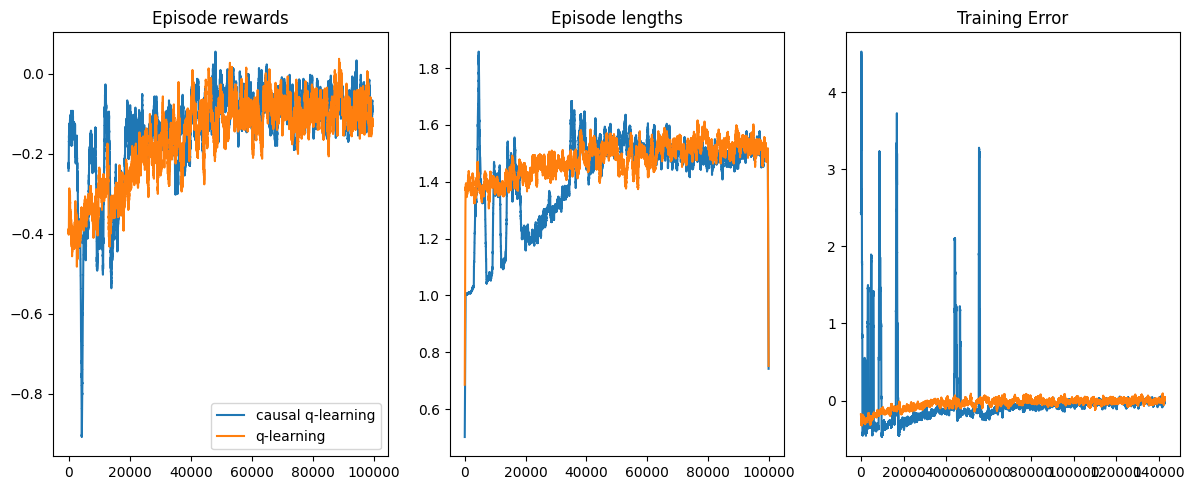

In [16]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
causal_reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), causal_reward_moving_average, label='causal q-learning')
axs[0].plot(range(len(reward_moving_average)), reward_moving_average, label='q-learning')
axs[1].set_title("Episode lengths")

causal_length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), causal_length_moving_average)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
causal_training_error_moving_average = (
    np.convolve(np.array(causal_agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
# Adjust the length of training_error_moving_average to match causal_training_error_moving_average
adjusted_length = len(causal_training_error_moving_average)
training_error_moving_average_adjusted = training_error_moving_average[:adjusted_length]

axs[2].plot(range((adjusted_length)), causal_training_error_moving_average)
axs[2].plot(range((adjusted_length)), training_error_moving_average_adjusted)
axs[0].legend()
plt.tight_layout()
plt.show()

In [17]:
#env2 = gym.make("Blackjack-v1", sab=True)
#env2 = gym.wrappers.RecordEpisodeStatistics(env2, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = baseline_agent.get_action(obs)
        
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs


100%|██████████| 100000/100000 [00:09<00:00, 10778.67it/s]


## Plots


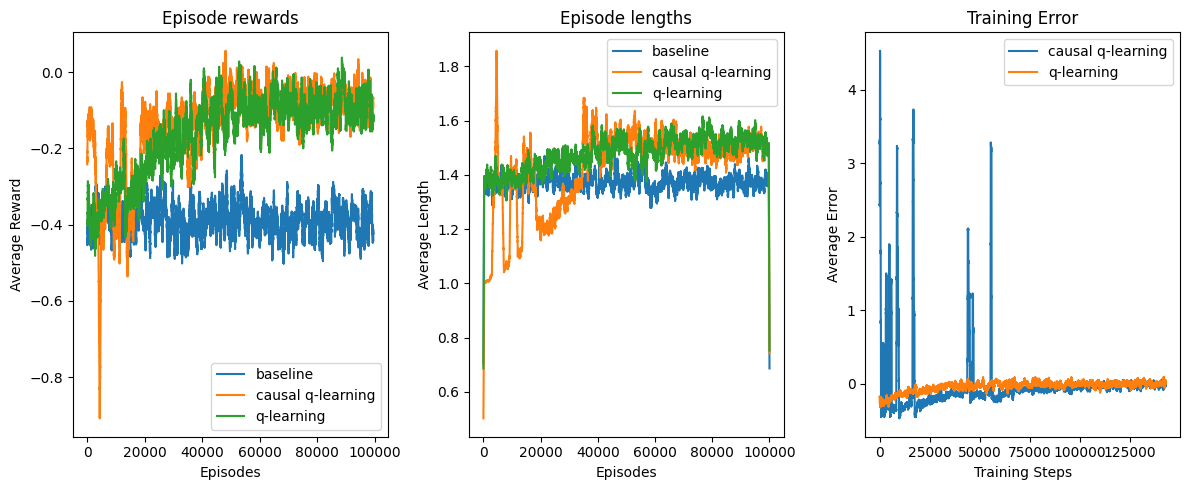

In [18]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
baseline_reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), baseline_reward_moving_average, label='baseline')
axs[0].plot(range(len(reward_moving_average)), causal_reward_moving_average, label='causal q-learning')
axs[0].plot(range(len(reward_moving_average)), reward_moving_average, label='q-learning')
axs[0].set_title("Episode rewards")
axs[0].set_xlabel("Episodes") # X-axis label for the first subplot
axs[0].set_ylabel("Average Reward") # Y-axis label for the first subplot
axs[0].legend()
axs[1].set_title("Episode lengths")

baseline_length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), baseline_length_moving_average, label='baseline')
axs[1].plot(range(len(length_moving_average)), causal_length_moving_average, label='causal q-learning')
axs[1].plot(range(len(length_moving_average)), length_moving_average, label='q-learning')
axs[1].set_title("Episode lengths")
axs[1].set_xlabel("Episodes") # X-axis label for the second subplot
axs[1].set_ylabel("Average Length") # Y-axis label for the second subplot
axs[1].legend()
axs[2].set_title("Training Error")
causal_training_error_moving_average = (
    np.convolve(np.array(causal_agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
# Adjust the length of training_error_moving_average to match causal_training_error_moving_average
adjusted_length = len(causal_training_error_moving_average)
training_error_moving_average_adjusted = training_error_moving_average[:adjusted_length]

axs[2].plot(range((adjusted_length)), causal_training_error_moving_average, label='causal q-learning')
axs[2].plot(range((adjusted_length)), training_error_moving_average_adjusted, label='q-learning')
axs[2].set_title("Training Error")
axs[2].set_xlabel("Training Steps") # X-axis label for the third subplot
axs[2].set_ylabel("Average Error") # Y-axis label for the third subplot

axs[2].legend()
plt.tight_layout()
plt.show()

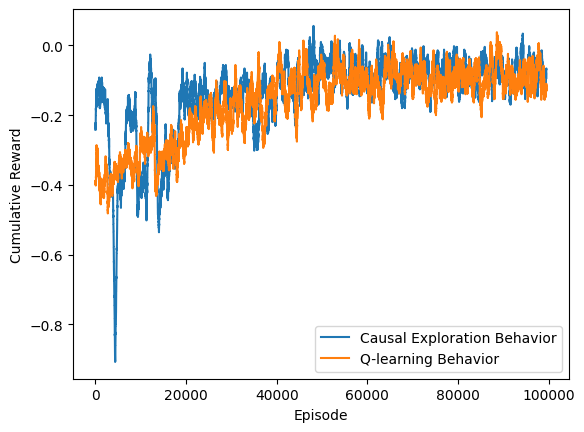

In [19]:
plt.plot(range(len(reward_moving_average)), causal_reward_moving_average,  label='Causal Exploration Behavior')
plt.plot(range(len(reward_moving_average)), reward_moving_average,  label='Q-learning Behavior')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()  # Ajoute la légende
plt.show()

In [20]:
print(causal_agent.causal_model)

Graph Nodes:
X1;X2;X3

Graph Edges:
1. X1 --- X2
2. X1 --- X3
3. X2 --- X3



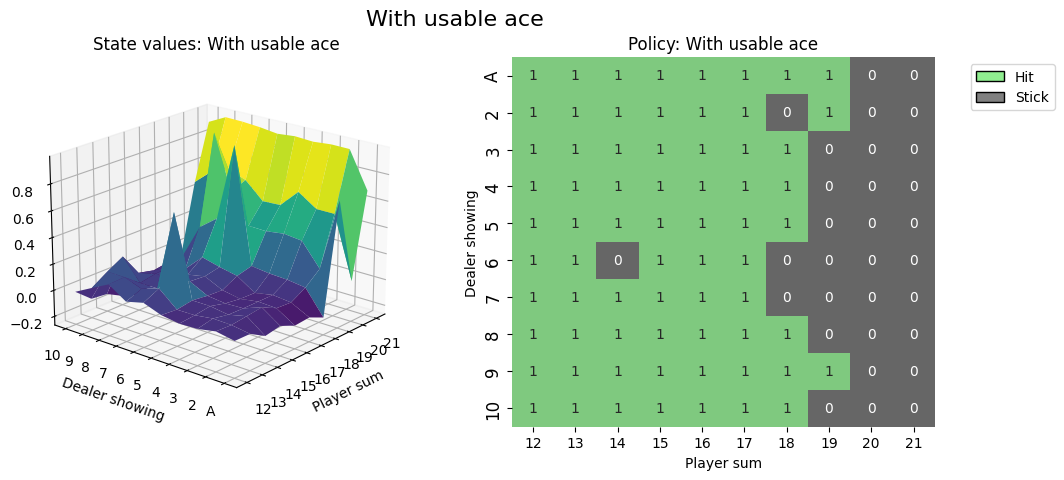

In [21]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(causal_agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

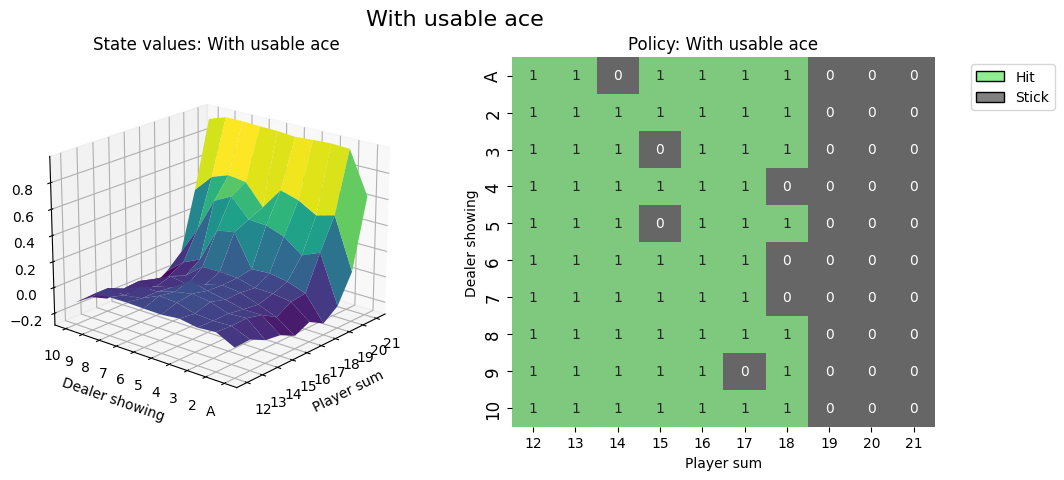

In [22]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [23]:
import scipy.stats as stats

# Assuming cumulative_rewards and causal_cumulative_rewards are your data arrays

# Performing a paired t-test
t_stat, p_value = stats.ttest_rel(reward_moving_average, causal_reward_moving_average)

print("T-statistic:", t_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference between the two sets of rewards.")
else:
    print("There is no significant difference between the two sets of rewards.")


T-statistic: -89.80279365716244
P-value: 0.0
There is a significant difference between the two sets of rewards.


In [24]:
import numpy as np
import scipy.stats as stats

# Assuming reward_moving_average and causal_reward_moving_average are your data arrays

# Calculate means and standard deviations
mean_reward = np.mean(reward_moving_average)
std_reward = np.std(reward_moving_average)
mean_causal_reward = np.mean(causal_reward_moving_average)
std_causal_reward = np.std(causal_reward_moving_average)

print("Mean of reward moving average:", mean_reward)
print("Standard deviation of reward moving average:", std_reward)
print("Mean of causal reward moving average:", mean_causal_reward)
print("Standard deviation of causal reward moving average:", std_causal_reward)

# Performing a paired t-test
t_stat, p_value = stats.ttest_rel(reward_moving_average, causal_reward_moving_average)

print("T-statistic:", t_stat)
print("P-value:", p_value)

if p_value < 0.05:
	print("There is a significant difference between the two sets of rewards.")
else:
	print("There is no significant difference between the two sets of rewards.")

Mean of reward moving average: -0.16198894483472526
Standard deviation of reward moving average: 0.10340012384223737
Mean of causal reward moving average: -0.13686998120621907
Standard deviation of causal reward moving average: 0.11269410756222388
T-statistic: -89.80279365716244
P-value: 0.0
There is a significant difference between the two sets of rewards.


Mean of reward moving average: -0.16198894483472526
Standard deviation of reward moving average: 0.10340012384223737
Mean of causal reward moving average: -0.13686998120621907
Standard deviation of causal reward moving average: 0.11269410756222388
T-statistic: -89.80279365716244
P-value: 0.0
There is a significant difference between the two sets of rewards.


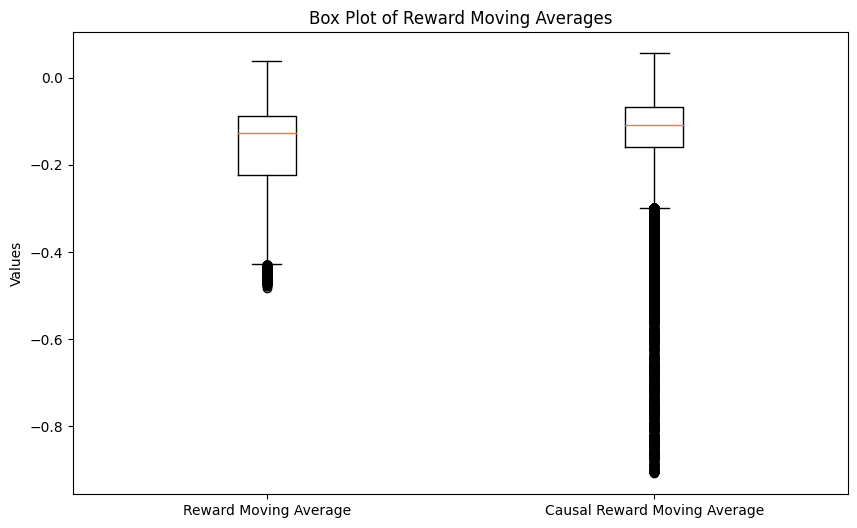

In [25]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Assuming reward_moving_average and causal_reward_moving_average are your data arrays

# Calculate means and standard deviations
mean_reward = np.mean(reward_moving_average)
std_reward = np.std(reward_moving_average)
mean_causal_reward = np.mean(causal_reward_moving_average)
std_causal_reward = np.std(causal_reward_moving_average)

print("Mean of reward moving average:", mean_reward)
print("Standard deviation of reward moving average:", std_reward)
print("Mean of causal reward moving average:", mean_causal_reward)
print("Standard deviation of causal reward moving average:", std_causal_reward)

# Performing a paired t-test
t_stat, p_value = stats.ttest_rel(reward_moving_average, causal_reward_moving_average)

print("T-statistic:", t_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference between the two sets of rewards.")
else:
    print("There is no significant difference between the two sets of rewards.")

# Plotting the box plots
data = [reward_moving_average, causal_reward_moving_average]
labels = ['Reward Moving Average', 'Causal Reward Moving Average']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Reward Moving Averages')
plt.ylabel('Values')
plt.show()

Other task

In [26]:
%pip install cython        


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
%load_ext cython

In [28]:
%%cython -a

import numpy as np
from tqdm import tqdm

class QLearningAgent:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.num_actions = len(env.actions) 
        self.Q = {}  # Dictionary to store Q-values
        
    def update_Q(self, state, action, reward, next_state):
        # Convert states to tuple keys if they are not already
        state_key = tuple(state.ravel()) if isinstance(state, (np.ndarray)) else state
        next_state_key = tuple(next_state.ravel()) if isinstance(next_state, (np.ndarray)) else next_state
        # Initialize Q-values for unseen states
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(self.num_actions)
        if next_state_key not in self.Q:
            self.Q[next_state_key] = np.zeros(self.num_actions)
        # Update Q-value using the Q-learning formula
        old_q_value = self.Q[state_key][action]
        max_next_q_value = np.max(self.Q[next_state_key])
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_next_q_value - old_q_value)
        self.Q[state_key][action] = new_q_value
        
    def choose_action(self, state):
        
        # Ensure state is converted to a hashable type (tuple) if it's a numpy array
        state_key = tuple(state.ravel()) if isinstance(state, np.ndarray) else state
        # Decide to explore or exploit
        if state_key not in self.Q or np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)  # Explore
        else:
            return np.argmax(self.Q[state_key])  # Exploit
            
    def train(self, num_episodes):
        cumulative_rewards = []
        exploration_behavior = []
        for episode in tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            episode_reward = 0
            exploration_count = 0
            
            for _ in (range(100)):
                action = self.choose_action(state)
                if np.random.rand() < self.epsilon:
                    exploration_count += 1
                next_state, reward, done, _ = self.env.step(action)
                self.update_Q(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                
            cumulative_rewards.append(episode_reward)
            exploration_behavior.append(exploration_count)
            self.epsilon *= self.epsilon_decay

        return cumulative_rewards, exploration_behavior


class BaselineAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.num_actions = len(env.actions) 
        self.Q = {}  # Dictionary to store Q-values
        
    def update_Q(self, state, action, reward, next_state):
        # Convert states to tuple keys if they are not already
        state_key = tuple(state.ravel()) if isinstance(state, (np.ndarray)) else state
        next_state_key = tuple(next_state.ravel()) if isinstance(next_state, (np.ndarray)) else next_state
        # Initialize Q-values for unseen states
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(self.num_actions)
        if next_state_key not in self.Q:
            self.Q[next_state_key] = np.zeros(self.num_actions)
        # Update Q-value using the Q-learning formula
        old_q_value = self.Q[state_key][action]
        max_next_q_value = np.max(self.Q[next_state_key])
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_next_q_value - old_q_value)
        self.Q[state_key][action] = new_q_value
        
    def choose_action(self, state):
        
        # Ensure state is converted to a hashable type (tuple) if it's a numpy array
        state_key = tuple(state.ravel()) if isinstance(state, np.ndarray) else state
        # Decide to explore or exploit
        if state_key not in self.Q or np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)  # Explore
        else:
            return np.random.randint(self.num_actions)  # Exploit
            
    def train(self, num_episodes):
        cumulative_rewards = []
        exploration_behavior = []
        for episode in tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            episode_reward = 0
            exploration_count = 0
            
            for _ in (range(100)):
                action = self.choose_action(state)
                if np.random.rand() < self.epsilon:
                    exploration_count += 1
                next_state, reward, done, _ = self.env.step(action)
                #self.update_Q(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                
            cumulative_rewards.append(episode_reward)
            exploration_behavior.append(exploration_count)
            self.epsilon *= self.epsilon_decay
        return cumulative_rewards, exploration_behavior


import numpy as np
from tqdm import tqdm

from cdt.metrics import precision_recall, SID, SHD
from tqdm import tqdm
from causallearn.search.ConstraintBased.PC import pc
from causallearn.graph import SHD


def shd_cl_metric(new_graph, graph):

    metric = SHD.SHD(new_graph, graph)

    return metric.get_shd()

def pc_algo(history):
    
    #print('pc hsitory', history)
    array_data = np.array(history) #dicts_to_numpy_array(history)

    
    cg = pc(array_data, alpha=0.2, verbose=False, show_progress=False)     #, alpha=0.05, indep_test="chisq")
    

    return cg.G

class CausalQLearningAgent:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, beta=0.2):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.num_actions = len(env.actions) 
        self.beta = beta
        self.Q = {}  # Dictionary to store Q-values
        self.D = {}
        self.history = []
        self.causal_graph = None
        
        
    def update_Q(self, state, action, reward, next_state):
        # Convert states to tuple keys if they are not already
        state_key = tuple(state.ravel()) if isinstance(state, (np.ndarray)) else state
        next_state_key = tuple(next_state.ravel()) if isinstance(next_state, (np.ndarray)) else next_state

        # Initialize Q-values for unseen states
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(self.num_actions)
        if next_state_key not in self.Q:
            self.Q[next_state_key] = np.zeros(self.num_actions)

        # Update Q-value using the Q-learning formula
        old_q_value = self.Q[state_key][action]
        max_next_q_value = np.max(self.Q[next_state_key])
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_next_q_value - old_q_value)

        self.Q[state_key][action] = new_q_value

    def update_causal_graph(self, causal_discovery_algo=pc_algo, graph_distance_metric=shd_cl_metric):
        
        new_causal_graph = causal_discovery_algo(self.history) 

        if self.causal_graph == None:
            self.causal_graph = new_causal_graph

        graph_distance = graph_distance_metric(new_causal_graph, self.causal_graph) # un peu là aussi

        return new_causal_graph, graph_distance


    def update_D(self, action, graph_distance):

        
        if action not in self.D:
            self.D[action] = 0
        
        self.D[action] = self.beta * graph_distance
        
    def choose_action(self, state):
        
        # Ensure state is converted to a hashable type (tuple) if it's a numpy array
        state_key = tuple(state.ravel()) if isinstance(state, np.ndarray) else state

        # Decide to explore or exploit
        if state_key not in self.Q or np.random.rand() < self.epsilon:
            return np.argmax(self.D)  # Causal exploration

        else:
            return np.argmax(self.Q[state_key])  # Exploit


    def train(self, num_episodes):
        cumulative_rewards = []
        exploration_behavior = []

        for episode in tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            episode_reward = 0
            exploration_count = 0
            
            for _ in (range(100)):
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_Q(state, action, reward, next_state)

                self.history.append(next_state)
                
                if np.random.rand() < self.epsilon:
                    exploration_count += 1
                if len(self.history) > 5 and len(self.history) % 15 == 0:
                    new_causal_graph, graph_distance = self.update_causal_graph()
                    self.update_D(action, graph_distance)

                state = next_state
                episode_reward += reward
                

            cumulative_rewards.append(episode_reward)
            exploration_behavior.append(exploration_count)
            self.epsilon *= self.epsilon_decay

        return cumulative_rewards, exploration_behavior

import numpy as np
import scipy.stats as stats
from StructuralCausalModels.linear_structural_causal_model import LinearStructuralCausalModel
from StructuralCausalModels.structural_equation import StructuralEquation
import matplotlib.pyplot as plt

N = 100
# Define the discrete value sets
discrete_values_X0 = [i for i in range(-N, N)]
discrete_values_X1 = [i for i in range(-N, N)]
discrete_values_X2 = [i for i in range(-N, N)]

# Define the quantization function
def quantize(value, discrete_values):
    return [min(discrete_values, key=lambda x: abs(x - v)) for v in value]

class CausalEnv:
    def __init__(self, scm, actions):
        self.scm = scm 
        self.current_step = 0
        self.max_step = 1000
        self.actions = actions

    def step(self, action):
        if not (action == None):
            new_scm = self.scm.perform_intervention(actions[action].intervention)
            sample = new_scm.generate_data(nb_samples = 100)
            next_state = np.floor(sample.mean())
        else:
            sample = self.scm.generate_data(nb_samples = 100)
            next_state = np.floor(sample.mean())
            
        self.current_step += 1
        done = (self.current_step >= self.max_step)
        info = {}
        reward = self.compute_reward(next_state)
        return next_state.to_numpy(), reward, done, info

    def reset(self):
        sample = self.scm.generate_data(nb_samples=100)
        state = np.floor(sample.mean())
        reward = self.compute_reward(state)
        
        return state.to_numpy()

    def compute_reward(self, state):
        return state.to_numpy()[-1]

class Action:
    def __init__(self, intervention):
        self.intervention = intervention

        


intervention_X0_neg = StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u : quantize(u - 1, discrete_values_X0))
intervention_X0_pos =  StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u : quantize(u + 1, discrete_values_X0))
action_X0_pos = Action(intervention_X0_pos)
action_X0_neg = Action(intervention_X0_neg)

intervention_X1_neg = StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u - 1, discrete_values_X1))
intervention_X1_pos =  StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u + 1, discrete_values_X1))
action_X1_pos = Action(intervention_X1_pos)
action_X1_neg = Action(intervention_X1_neg)

intervention_X2_neg = StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u - 1, discrete_values_X2))
intervention_X2_pos = StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u + 1, discrete_values_X2))
action_X2_pos = Action(intervention_X2_pos)
action_X2_neg = Action(intervention_X2_neg)





actions = [action_X0_neg, action_X0_pos, action_X1_neg, action_X1_pos, action_X2_neg, action_X2_pos]

structural_equations = [
    StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u: quantize(u, discrete_values_X0)),
    StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u, discrete_values_X1)),
    StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u, discrete_values_X2))
]

# Create a linear SCM
linear_scm = LinearStructuralCausalModel(name='SCM', nb_var=3, structural_equations=structural_equations)

env = CausalEnv(scm=linear_scm, actions=actions)

# Initialize the Q-learning agent
baseline = BaselineAgent(env)
agent = QLearningAgent(env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99)
causal_agent = CausalQLearningAgent(env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, beta=10.0)

# Train the agent
num_episodes = 1000
baseline_rewards, baseline_exploration = baseline.train(num_episodes)
causal_cumulative_rewards, causal_exploration_behavior = causal_agent.train(num_episodes)
cumulative_rewards, exploration_behavior = agent.train(num_episodes)
# Plot cumulative reward
plt.figure(figsize=(10, 6))


No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
 64%|██████▍   | 641/1000 [29:54<04:28,  1.34it/s]    

In [ ]:
# Regroupement des données dans une liste pour le boxplot
data = [cumulative_rewards, causal_cumulative_rewards, baseline_rewards]

# Création du boxplot
plt.boxplot(data, patch_artist=True, showmeans=True, 
            positions=[1, 2, 3],  # Position de chaque boxplot
            widths=0.6)  # Largeur des boxplots pour éviter qu'ils soient trop étroits

# Ajout des étiquettes et du titre
plt.xticks([1, 2, 3], ['Q-learning', 'Causal Q-learning', 'Baseline'])
plt.ylabel('Cumulative reward')
#plt.title('Comparais')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Fenêtre pour la moyenne mobile
window_size = 20


# Calcul des moyennes mobiles
rolling_avg_cumulative_rewards = pd.Series(cumulative_rewards).rolling(window=window_size).mean()
rolling_avg_causal_cumulative_rewards = pd.Series(causal_cumulative_rewards).rolling(window=window_size).mean()
rolling_avg_baseline_rewards = pd.Series(baseline_rewards).rolling(window=window_size).mean()
rolling_avg_causal_exploration = pd.Series(causal_exploration_behavior).rolling(window=window_size).mean()
rolling_avg_exploration_behavior = pd.Series(exploration_behavior).rolling(window=window_size).mean()

# Tracé des graphiques avec moyennes mobiles
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), cumulative_rewards, label='Cumulative Reward', alpha=0.5)
plt.plot(range(num_episodes), rolling_avg_cumulative_rewards, label='Rolling Avg Cumulative Reward', linewidth=2)
plt.plot(range(num_episodes), causal_cumulative_rewards, label='Causal Cumulative Reward', alpha=0.5)
plt.plot(range(num_episodes), rolling_avg_causal_cumulative_rewards, label='Rolling Avg Causal Cumulative Reward', linewidth=2)
plt.plot(range(num_episodes), baseline_rewards, label='Baseline Cumulative Reward', alpha=0.5)
plt.plot(range(num_episodes), rolling_avg_baseline_rewards, label='Rolling Avg Baseline Reward', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Episodes')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), causal_exploration_behavior, label='Causal Exploration Behavior', alpha=0.5)
plt.plot(range(num_episodes), rolling_avg_causal_exploration, label='Rolling Avg Causal Exploration', linewidth=2)
plt.plot(range(num_episodes), exploration_behavior, label='Q-learning Exploration Behavior', alpha=0.5)
plt.plot(range(num_episodes), rolling_avg_exploration_behavior, label='Rolling Avg Q-learning Exploration', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Exploration Count')
plt.title('Exploration Behavior over Episodes')
plt.legend()
plt.show()